## **Предобработка данных**

# **Загрузка данных**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [3]:
# монтируем связь с google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Загружаем данные из Excel-файла
data_df = pd.read_excel('/content/drive/MyDrive/Данные_для_курсовои_Классическое_МО.xlsx')

# Выводим первые 5 строк DataFrame
print(data_df.head())

   Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0           0    6.239374  175.482382  28.125000           5.094096   
1           1    0.771831    5.402819   7.000000           3.961417   
2           2  223.808778  161.142320   0.720000           2.627117   
3           3    1.705624  107.855654  63.235294           5.097360   
4           4  107.131532  139.270991   1.300000           5.150510   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        5.094096           0.387225        0.387225  0.417362  42.928571   
1        3.961417           0.533868        0.533868  0.462473  45.214286   
2        2.627117           0.543231        0.543231  0.260923  42.187500   
3        5.097360           0.390603        0.390603  0.377846  41.862069   
4        5.150510           0.270476        0.270476  0.429038  36.514286   

   ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0  ...           0           

# **Обработка пропущенных значений**

In [5]:
# Подсчет пропусков до обработки
missing_before = data_df.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

# Заполнение пропусков медианой для числовых признаков
numeric_cols = data_df.select_dtypes(include=[np.number]).columns
data_df[numeric_cols] = data_df[numeric_cols].fillna(data_df[numeric_cols].median())

Missing values before: 36


# **Преобразование целевых показателей**

Исследование датасета - значений CC50, CI50, SI показывает, что минимальное и максимальное значение может отличаться в 1000 раз. Применим логарифмирование целевых пременных.

In [24]:
# Применение логарифмирования к целевым переменным CC50, CI50, SI
target_columns = ['CC50, mM', 'IC50, mM', 'SI']
for col in target_columns:
    if col in data_df.columns:
        # Применяем логарифмирование с добавлением 1 для избежания логарифма нуля
        data_df[col] = np.log1p(data_df[col])
        print(f"Lemogit transforming column: {col}")

Lemogit transforming column: CC50, mM
Lemogit transforming column: IC50, mM
Lemogit transforming column: SI


In [25]:
data_df = data_df.drop(columns=['Unnamed: 0'])

KeyError: "['Unnamed: 0'] not found in axis"

In [26]:
# Проверим, что наши показатели были преобразованы
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
"IC50, mM",1001.0,1.517820,0.455448,0.003504,1.281997,1.581557,1.859485,2.232797
"CC50, mM",1001.0,1.842629,0.307957,0.425989,1.725461,1.948923,2.053729,2.242907
SI,1001.0,1.013786,0.434700,0.011359,0.636186,0.947086,1.352221,2.366162
MaxAbsEStateIndex,1001.0,10.831637,3.307505,2.321942,9.252350,12.179236,13.167843,15.933463
MaxEStateIndex,1001.0,10.831637,3.307505,2.321942,9.252350,12.179236,13.167843,15.933463
...,...,...,...,...,...,...,...,...
fr_thiazole,1001.0,0.051948,0.222033,0.000000,0.000000,0.000000,0.000000,1.000000
fr_thiocyan,1001.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fr_thiophene,1001.0,0.069930,0.255157,0.000000,0.000000,0.000000,0.000000,1.000000
fr_unbrch_alkane,1001.0,0.204795,1.215326,0.000000,0.000000,0.000000,0.000000,20.000000


# **Исследование данных на корреляциию**

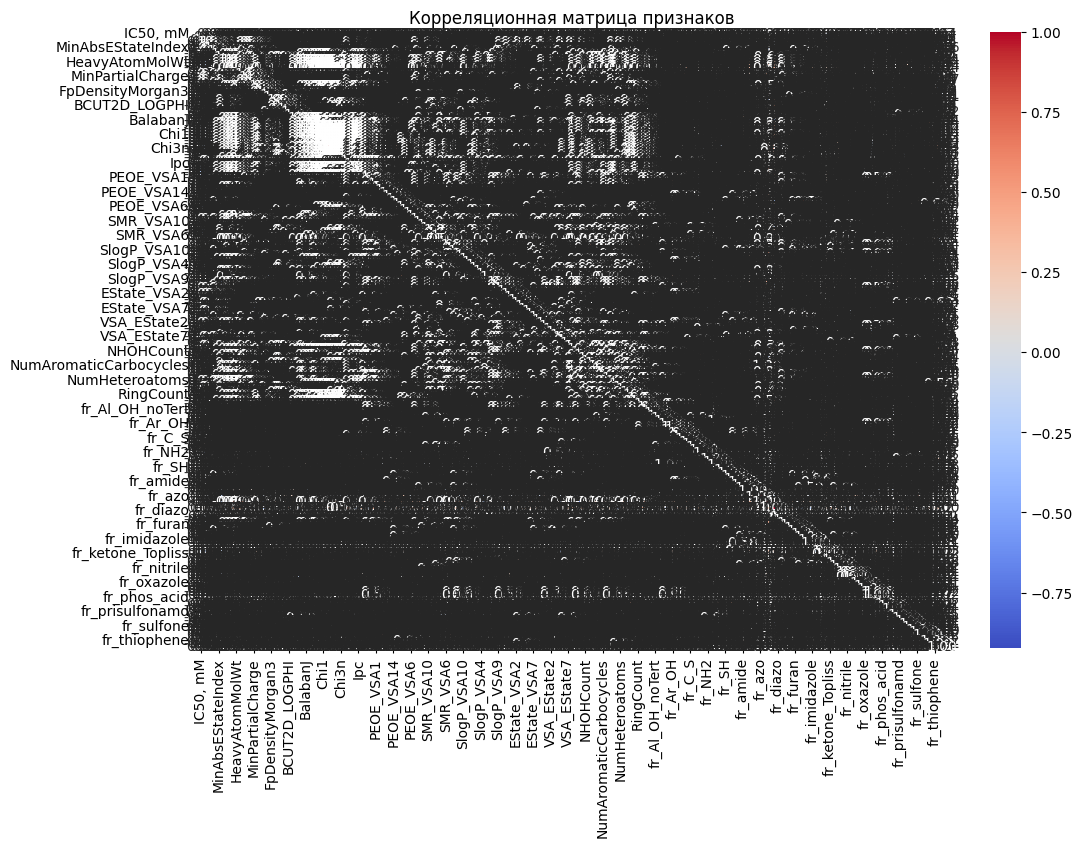

In [27]:
# Рассчитываем корреляционную матрицу
correlation_matrix = data_df.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица признаков")
plt.show()

   IC50, mM  CC50, mM        SI  MinAbsEStateIndex  MinEStateIndex       qed  \
0  1.091767  1.820221  1.475128           0.387225        0.387225  0.417362   
1  0.452357  1.049681  1.124748           0.533868        0.533868  0.462473   
2  1.858678  1.806398  0.433291           0.543231        0.543231  0.260923   
3  0.690811  1.738714  1.641431           0.390603        0.390603  0.377846   
4  1.737541  1.782311  0.605904           0.270476        0.270476  0.429038   

         SPS  NumRadicalElectrons  BCUT2D_MWHI  BCUT2D_MWLOW  ...  fr_sulfide  \
0  42.928571                    0    14.822266      9.700470  ...           0   
1  45.214286                    0    14.975110      9.689226  ...           0   
2  42.187500                    0    15.353938      9.681293  ...           0   
3  41.862069                    0    14.821216      9.700497  ...           0   
4  36.514286                    0    14.831112      9.700386  ...           0   

   fr_sulfonamd  fr_sulfone  fr_

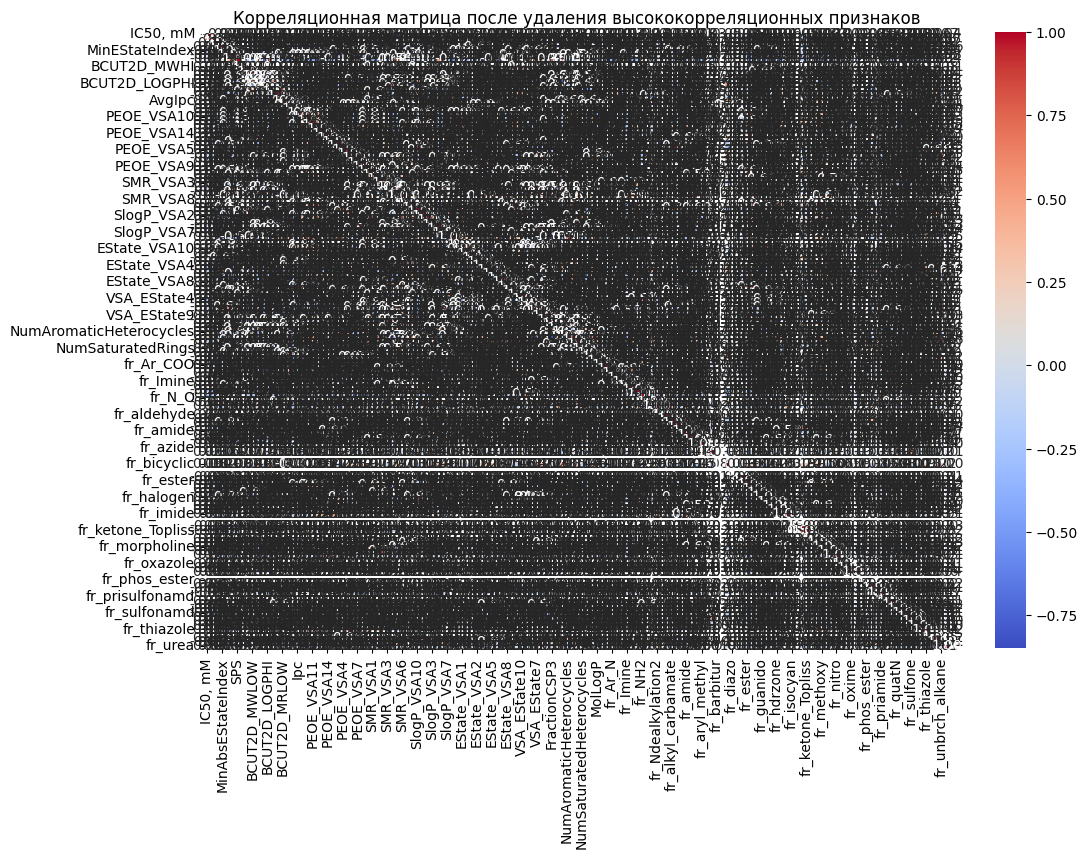

In [30]:
# Задаем порог для корреляции
threshold = 0.9

# Список для хранения признаков, которые нужно удалить
to_drop = []

# Перебираем пары признаков
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        # Проверяем, является ли корреляция выше порога и не равна ли она 1
        if col != row and abs(correlation_matrix[col][row]) > threshold:
            to_drop.append(row)

# Удаляем дубликаты и оставляем только уникальные названия признаков
to_drop = list(set(to_drop))

# Удаляем высококоррелированные признаки из DataFrame
data_df_cleaned = data_df.drop(columns=to_drop)

# Выводим очищенный DataFrame
print(data_df_cleaned.head())

# Для визуализации скорректированной корреляционной матрицы
correlation_matrix_cleaned = data_df_cleaned.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица после удаления высококорреляционных признаков")
plt.show()

# **Обработка выбросов**

In [35]:
# Функция для удаления выбросов на основе IQR
def remove_outliers_iqr(df):
    # Копируем DataFrame для избежания изменения оригинала
    df_no_outliers = df.copy()

    for col in df_no_outliers.select_dtypes(include=[float, int]).columns:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Удаляем выбросы
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

    return df_no_outliers

# Применяем функцию к очищенному DataFrame
data_df_final = remove_outliers_iqr(data_df_cleaned)

# Выводим результат
print(data_df_final.head())

     IC50, mM  CC50, mM        SI  MinAbsEStateIndex  MinEStateIndex  \
19   1.644109  1.894795  0.989761           0.300347        0.300347   
754  1.583342  1.841070  0.978030           0.300347        0.300347   
757  0.908746  1.660644  1.404296           0.300347        0.300347   
758  0.741793  1.660644  1.522127           0.300347        0.300347   
759  1.032423  1.660644  1.305647           0.300347        0.300347   

          qed        SPS  NumRadicalElectrons  BCUT2D_MWHI  BCUT2D_MWLOW  ...  \
19   0.562066  60.272727                    0    14.788664      9.531931  ...   
754  0.562066  60.272727                    0    14.788664      9.531931  ...   
757  0.562066  60.272727                    0    14.788664      9.531931  ...   
758  0.562066  60.272727                    0    14.788664      9.531931  ...   
759  0.562066  60.272727                    0    14.788664      9.531931  ...   

     fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
19

# **Подготовка данных**

In [38]:
# Целевая переменная
y = np.log1p(data_df_final['IC50, mM'])  # Логарифмическое преобразование

# Признаки
X = data_df_final.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)

# Удаление константных столбцов
constant_columns = [col for col in X.columns if X[col].nunique() == 1]
X = X.drop(constant_columns, axis=1)

# Заполнение пропущенных значений
X = X.fillna(X.median())

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import warnings

# **Базовые модели регрессии**

In [43]:
# Список моделей для сравнения
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=42)),
    ('Lasso Regression', Lasso(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42))
]

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Словарь для хранения метрик
results = {}

# Обучаем и оцениваем каждую модель
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Вычисляем метрики
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Сохраняем результаты в словарь
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'R²': r2
    }

# Переводим результаты в DataFrame для удобства анализа
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='R²', ascending=False))

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 22, number of used features: 0
[LightGBM] [Info] Start training from score 0.863798
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

**Заключение**

Согласно предоставленным данным, для оценки производительности моделей можно обратить внимание на значение метрики надежности R². Эта метрика показывает, насколько хорошо модель может объяснять вариацию целевой переменной, и чем выше значение R², тем лучше модель.

В вашем случае модель LightGBM имеет наилучшее значение R², равное -0.238234, что указывает на наименьшее количество ошибок среди всех протестированных моделей. Кроме того, среди других моделей, таких как Random Forest, XGBoost, Ridge Regression, Gradient Boosting и Linear Regression, все они имеют значения R² значительно ниже нуля, что говорит о том, что они не являются хорошими кандидатами для предсказания в данном наборе данных.

Сравнивая метрики MAE и MSE, можно заметить, что Lasso Regression тоже показала хорошие результаты с минимальными значениями MAE и MSE по сравнению с другими моделями. Однако, по R² LightGBM значительно обходит другие модели.

Итак, можно сделать вывод, что в предоставленном списке моделей лучше всего работает LightGBM, а Lasso Regression также показала себя достойно, хоть и не так хорошо, как LightGBM по R².